# Import Libraries

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import os
import json

# Setup Device

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [33]:
device

device(type='cuda')

# Model Architecture

In [31]:
class LayersLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=8,dropout=0.0):
        super(LayersLSTM, self).__init__()

        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers,
                             batch_first=True)

        # Fully connected layer for output
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Forward propagate through LSTM
        lstm_out, _ = self.lstm(x)

        # Get the output from the last time step
        last_time_step = lstm_out[:, -1, :]
        self.last_time_step = last_time_step

        output=self.fc(self.last_time_step)

        return output

# Model Evaluation

In [2]:
dir=os.path.join("..","reports")

## With different stack layers

In [19]:
with open(os.path.join(dir,"2_layers_lstm_training_report.json"),"r") as f:
    lstm_with_2_layers=json.load(f)
    
with open(os.path.join(dir,"3_layers_lstm_training_report.json"),"r") as f:
    lstm_with_3_layers=json.load(f)

with open(os.path.join(dir,"4_layers_lstm_training_report.json"),"r") as f:
    lstm_with_4_layers=json.load(f)

with open(os.path.join(dir,"5_layers_lstm_training_report.json"),"r") as f:
    lstm_with_5_layers=json.load(f)


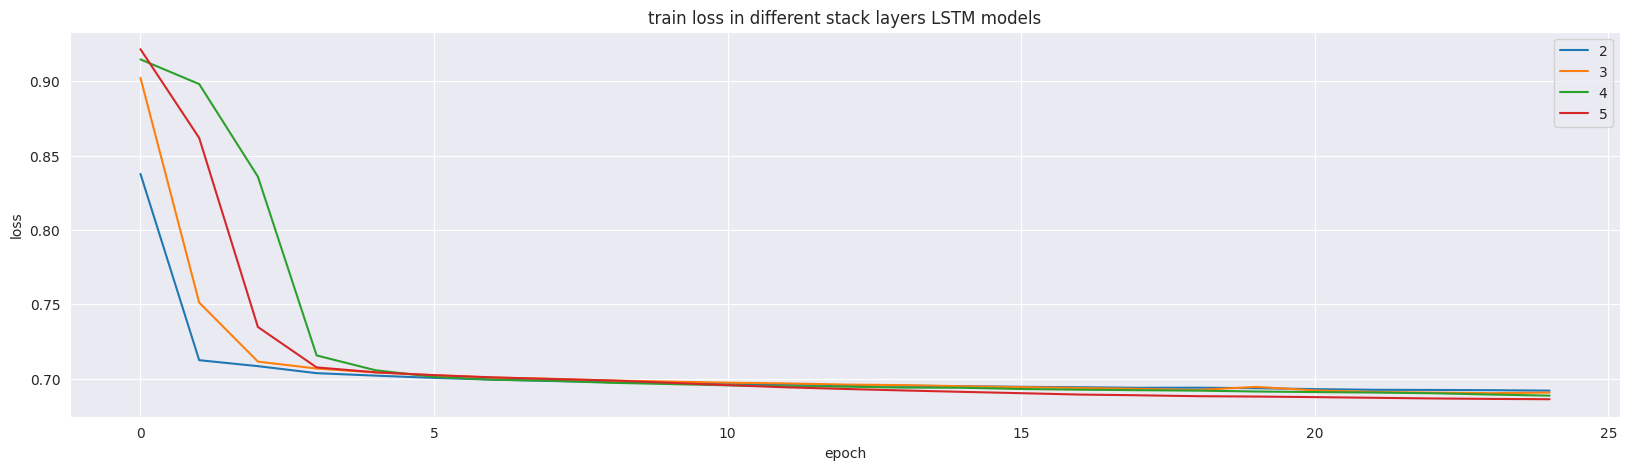

In [20]:
plt.figure(figsize=(20,5))
plt.title("train loss in different stack layers LSTM models")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(lstm_with_2_layers["loss"],label="2")
plt.plot(lstm_with_3_layers["loss"],label="3")
plt.plot(lstm_with_4_layers["loss"],label="4")
plt.plot(lstm_with_5_layers["loss"],label="5")
plt.legend()
plt.show()

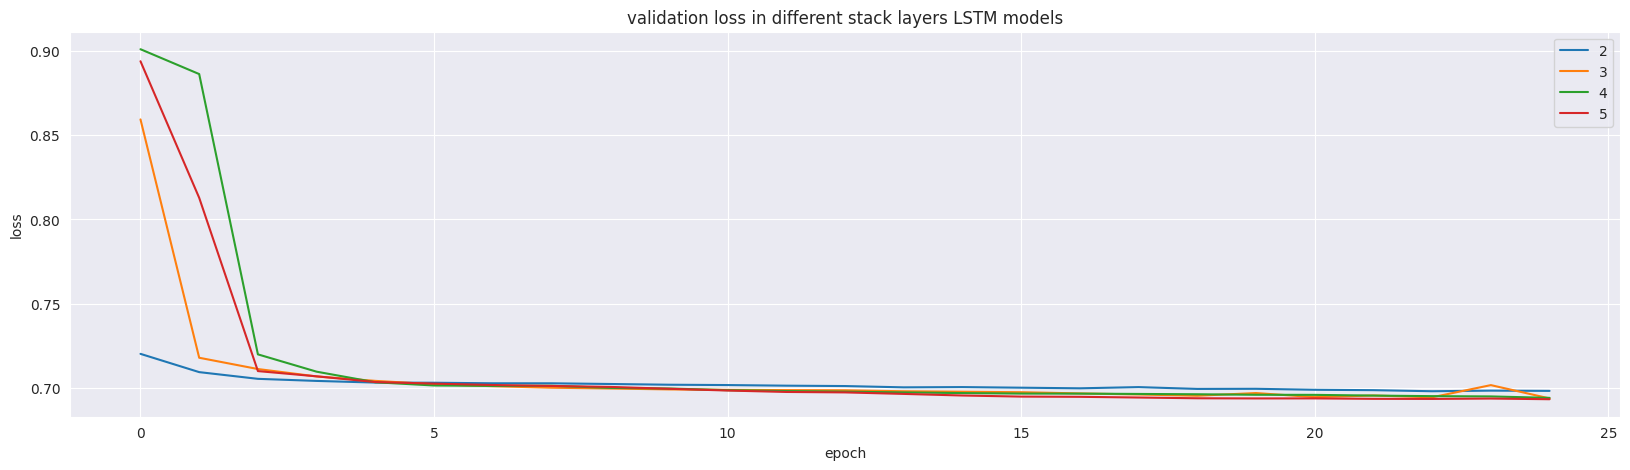

In [21]:
plt.figure(figsize=(20,5))
plt.title("validation loss in different stack layers LSTM models")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(lstm_with_2_layers["validation loss"],label="2")
plt.plot(lstm_with_3_layers["validation loss"],label="3")
plt.plot(lstm_with_4_layers["validation loss"],label="4")
plt.plot(lstm_with_5_layers["validation loss"],label="5")
plt.legend()
plt.show()

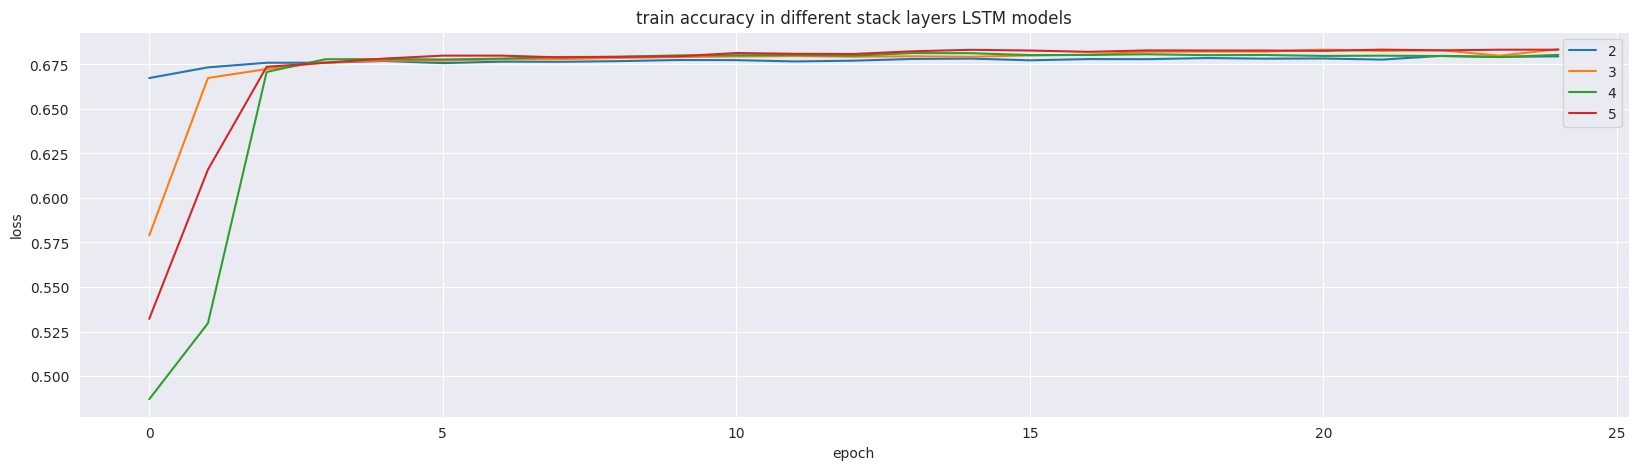

In [22]:
plt.figure(figsize=(20,5))
plt.title("train accuracy in different stack layers LSTM models")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(lstm_with_2_layers["accuracy"],label="2")
plt.plot(lstm_with_3_layers["accuracy"],label="3")
plt.plot(lstm_with_4_layers["accuracy"],label="4")
plt.plot(lstm_with_5_layers["accuracy"],label="5")
plt.legend()
plt.show()

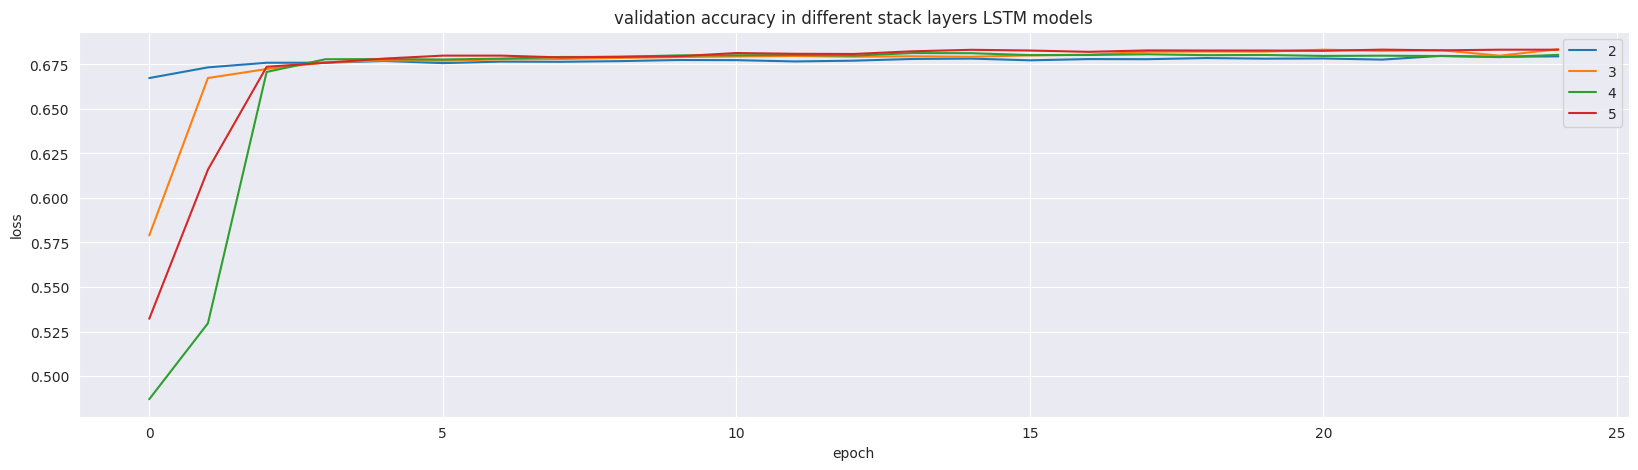

In [23]:
plt.figure(figsize=(20,5))
plt.title("validation accuracy in different stack layers LSTM models")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(lstm_with_2_layers["validation accuracy"],label="2")
plt.plot(lstm_with_3_layers["validation accuracy"],label="3")
plt.plot(lstm_with_4_layers["validation accuracy"],label="4")
plt.plot(lstm_with_5_layers["validation accuracy"],label="5")
plt.legend()
plt.show()

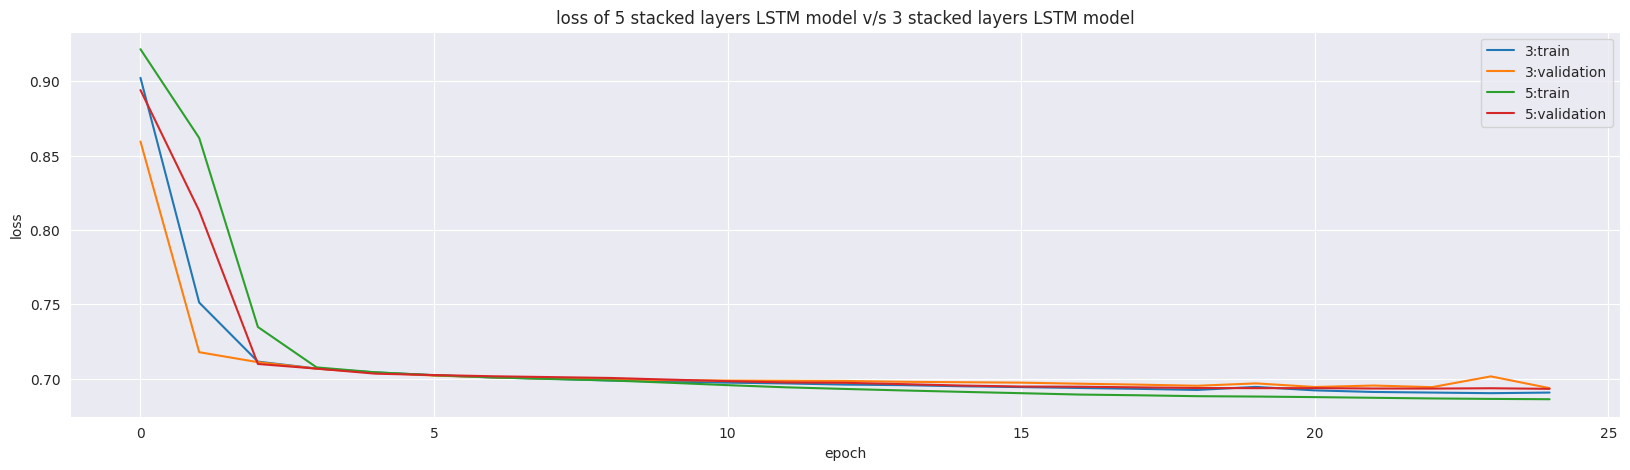

In [24]:
plt.figure(figsize=(20,5))
plt.title("loss of 5 stacked layers LSTM model v/s 3 stacked layers LSTM model")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(lstm_with_3_layers["loss"],label="3:train")
plt.plot(lstm_with_3_layers["validation loss"],label="3:validation")
plt.plot(lstm_with_5_layers["loss"],label="5:train")
plt.plot(lstm_with_5_layers["validation loss"],label="5:validation")
plt.legend()
plt.show()

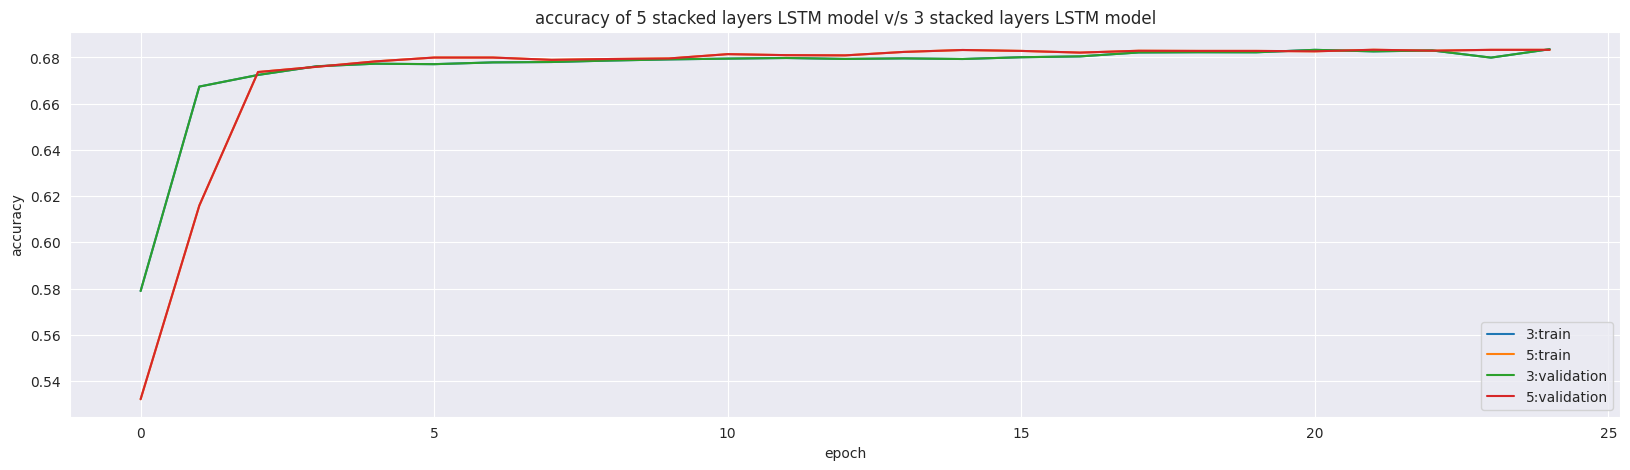

In [25]:
plt.figure(figsize=(20,5))
plt.title("accuracy of 5 stacked layers LSTM model v/s 3 stacked layers LSTM model")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.plot(lstm_with_3_layers["accuracy"],label="3:train")
plt.plot(lstm_with_5_layers["accuracy"],label="5:train")
plt.plot(lstm_with_3_layers["validation accuracy"],label="3:validation")
plt.plot(lstm_with_5_layers["validation accuracy"],label="5:validation")
plt.legend()
plt.show()

### Observations:
- **In loss, The performance of the 3 stacked layers LSTM model and the 5 stacked layers LSTM model are better than other LSTM models with different stacked layers.**
- **In terms of accuracy, both 3 stacked and 5 stacked layers LSTM models have better performance, but a certain epochs the 3 stacked layers LSTM model outperform the 5 stacked layers LSTM model.**
- **we can see there is a slightly overfitting in the 3 stacked layers LSTM model at certain point unlike the 5 stacked layers LSTM model.**
- **The 5 stacked layers LSTM model computationally expensive compare to the 3 stacked layers LSTM model.**
- **Overall, LSTM with 3 stacked layers better to have.**

In [26]:
np.max(lstm_with_3_layers["accuracy"])

0.6835666666666667

In [28]:
lstm_with_3_layers["accuracy"].index(0.6835666666666667)

24

# Model Load

In [34]:
model=LayersLSTM(input_size=64, hidden_size=5, output_size=3,num_layers=3).to(device)

In [37]:
model.load_state_dict(torch.load('../models/3_layers_lstm_model_weights.pth',weights_only=True))
model.eval()

LayersLSTM(
  (lstm): LSTM(64, 5, num_layers=3, batch_first=True)
  (fc): Linear(in_features=5, out_features=3, bias=True)
)

# Prediction

### Train Dataset

In [39]:
train_games_tensor = np.memmap("../data/numpy_objects/train_games_tensor.dat", dtype='float64', mode='r',
                               shape=(240000, 64, 64))
train_y = np.load("../data/numpy_objects/train_target.npy")

train_y_hat=np.zeros_like(train_y)

batch_size=10000
batch_num= train_games_tensor.shape[0]//batch_size

for i in range(batch_num):
    input_x=np.array(train_games_tensor[i*batch_size:(i+1)*batch_size,:])
    input_x=torch.from_numpy(input_x).float().to(device)
    with torch.no_grad():
        y_hat_matrix=model(input_x)
        _,y_hat = torch.max(y_hat_matrix,dim=1)
        train_y_hat[i*batch_size:(i+1)*batch_size]=y_hat.cpu().numpy()
    

### validation Dataset

In [40]:
validation_games_tensor = np.memmap("../data/numpy_objects/val_games_tensor.dat", dtype='float64', mode='r',
                               shape=(30000, 64, 64))
validation_y = np.load("../data/numpy_objects/val_target.npy")


input_x=np.array(validation_games_tensor)
input_x=torch.from_numpy(input_x).float().to(device)
with torch.no_grad():
    y_hat_matrix=model(input_x)
    _,y_hat = torch.max(y_hat_matrix,dim=1)
    validation_y_hat=y_hat.cpu().numpy()

### Test Dataset

In [42]:
test_games_tensor = np.memmap("../data/numpy_objects/test_games_tensor.dat", dtype='float64', mode='r',
                               shape=(30000, 64, 64))
test_y = np.load("../data/numpy_objects/test_target.npy")

input_x=np.array(test_games_tensor)
input_x=torch.from_numpy(input_x).float().to(device)
with torch.no_grad():
    y_hat_matrix=model(input_x)
    _,y_hat = torch.max(y_hat_matrix,dim=1)
    test_y_hat=y_hat.cpu().numpy()

# Metrices

In [43]:
from sklearn.metrics import confusion_matrix,accuracy_score

In [44]:
print(f"train accuracy: {accuracy_score(train_y,train_y_hat)}")
print(f"validation accuracy: {accuracy_score(validation_y,validation_y_hat)}")
print(f"test accuracy: {accuracy_score(test_y,test_y_hat)}")

train accuracy: 0.6846833333333333
validation accuracy: 0.6835666666666667
test accuracy: 0.46176666666666666


In [45]:
confusion_matrix(train_y,train_y_hat)

array([[74857, 30504,     0],
       [25634, 89467,     0],
       [ 8661, 10877,     0]])

In [46]:
confusion_matrix(validation_y,validation_y_hat)

array([[ 9431,  3946,     0],
       [ 3160, 11076,     0],
       [ 1074,  1313,     0]])

In [47]:
confusion_matrix(test_y,test_y_hat)

array([[6068, 7309,    0],
       [6451, 7785,    0],
       [1100, 1287,    0]])